# **MetaboTandem**

# 2. Data Pre-processing

This Notebook allows the preprocessing of the LC-MS/MS data. 
Pre-processing in untargeted metabolomics experiments aims at quantifying the signal from individual ion species in a data set. It consists of 3 main steps: 
- **Chromatographic peak detection**
- **Alignment**
- **Correspondence** 

The resulting matrix of feature abundances can then be used as an input in downstream analyses.


## 1.2 Load libraries

In [1]:
library(xcms)
library(tidyverse)
library(ggpubr)

Loading required package: BiocParallel

Loading required package: MSnbase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welco

## 2.1 User inputs required <====

#### a. Pre-loaded LC-MS/MS data
Please enter the path to the the R object containing the LC-MS/MS data. This object can be created with the previous script `1_data_import.ipynb`


In [2]:
data_file  <- '../../data/imported_data.RData'

#### c. Variable to color
Set which variable will be used for coloring plots

In [3]:
color_by <- 'treatment'

## 2.2 Load data

In [17]:
load(data_file)

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 0.03 Mb
- - - Spectra data - - -
 MS level(s): 1 2 
 Number of spectra: 4 
 MSn retention times: 0:00 - 0:04 minutes
- - - Processing information - - -
Data loaded [Mon Feb 14 15:05:33 2022] 
 MSnbase version: 2.18.0 
- - - Meta data  - - -
phenoData
  rowNames: 1
  varLabels: FileName SampleID treatment time
  varMetadata: labelDescription
Loaded from:
  Control-T1.mzXML 
protocolData: none
featureData
  featureNames: F1.S0001 F1.S0002 F1.S0003 F1.S0004
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'

## 2.3 Initial data visualization

Set colors for plots.

In [5]:
# Create color palette
color_list <- get_palette(palette = 'Dark2', length(unique(as_vector(metadata[,color_by]))))
names(color_list) <- unique(as_vector(metadata[,color_by]))

# Create vector of color for plots
color_vector <- c(rep(color_list, each = 2))
color_vector

Control   Control  Inoculum  Inoculum 
"#1B9E77" "#1B9E77" "#7570B3" "#7570B3"

Provides an initial visualization of the **total ion chromatogram (TIC)** and the **base peak chromatogram (BPC)** of your data.

In [6]:
# Extract chromatograms
tic <- chromatogram(data, aggregationFun="sum")
bpc <- chromatogram(data, aggregationFun="max")

#### Plot TIC

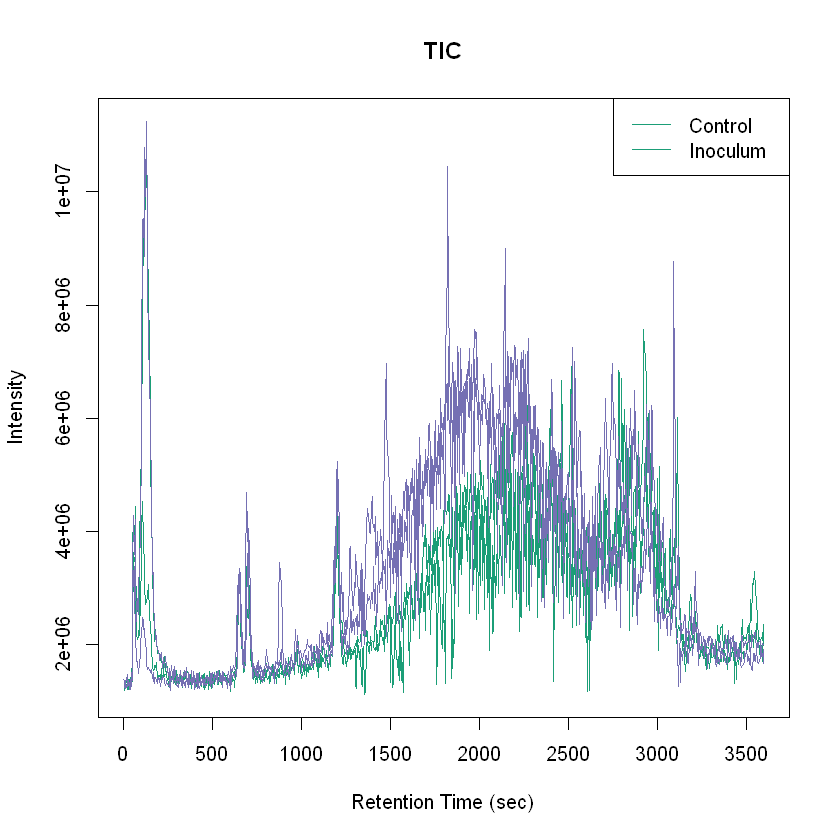

In [8]:
plot(tic, col = color_vector, ylab = "Intensity", xlab = "Retention Time (sec)", main = 'TIC')
legend("topright", legend = unique(as_vector(metadata[,color_by])), col = color_vector, lty=1)

#### Plot BPC

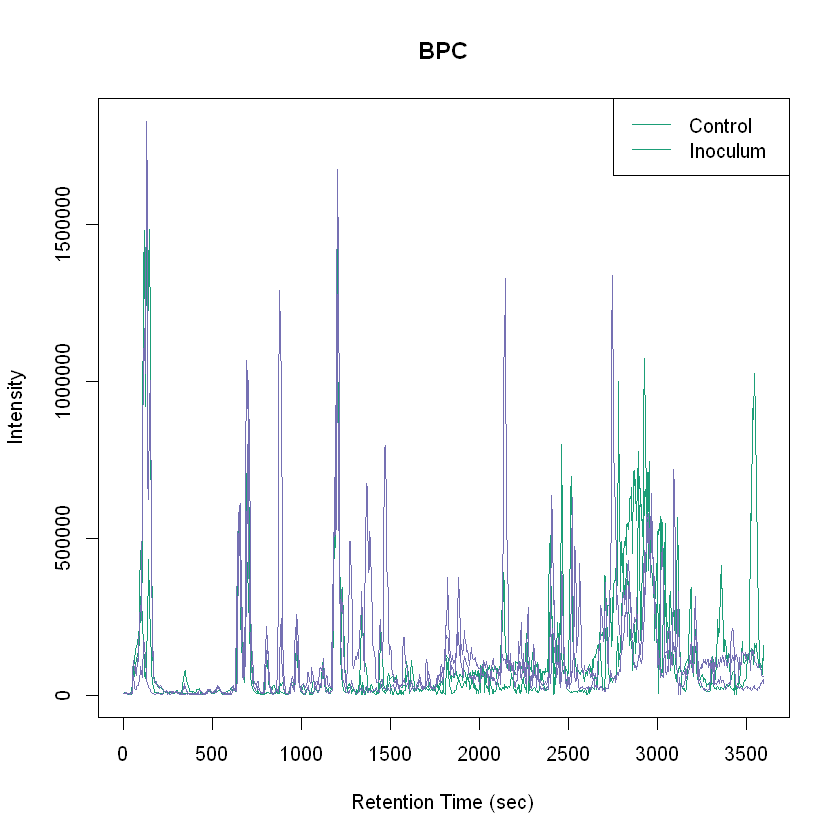

In [9]:
plot(bpc, col = color_vector, ylab="Intensity", xlab="Retention Time (sec)", main= 'BPC')
legend("topright", legend=unique(as_vector(metadata[,color_by])), col = color_vector, lty=1)

## 2.4 Chromatographic peak detection

### Testing peak detection parameters <==== User inputs required

#### Peaks for visualize the samples
Please enter ranges of masses (*m/z*) and retention times (*rt*, in seconds) for a couple of peaks to visualize how your data respond to the selected parameters

In [19]:
mzr1  <- c(550, 600)
rt1  <- c(900, 1200)

#### Parameters for peak picking

In [20]:
cwp <- CentWaveParam(
    peakwidth = c(10, 50), 
    ppm = 25,
    snthresh = 3, # default
    noise = 2.5e5,
    mzdiff = -0.001,
    prefilter = c(1, 100))

#### Testing parameters

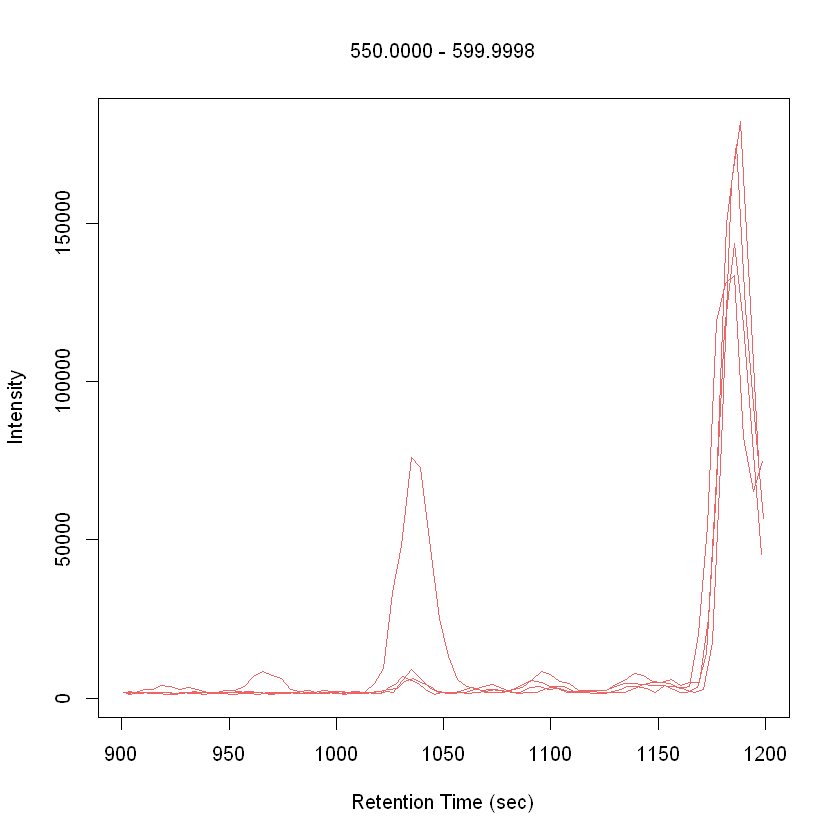

In [22]:
data %>% 
    filterRt(rt = rt1) %>% 
    filterMz(mz = mzr1) %>% 
    chromatogram(., aggregationFun="max") %>% 
      findChromPeaks(., param = cwp) %>% 
      plot(col = "indianred2", 
           ylab="Intensity", xlab="Retention Time (sec)",
           font.lab=1, cex.lab=1, cex.axis=1, font.main=1, cex.main=1)

#### Apply on full data

In [24]:
data <- findChromPeaks(data, param = cwp)


Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

#### Extracting peak information

In [29]:
chrom_peaks_df <- as.data.frame(chromPeaks(data))
n.peaks.sample <- chrom_peaks_df %>% count(sample)
colnames(n.peaks.sample) <- c('sampleIndex', 'totalPeaksDetected')
n.peaks.sample <- merge(n.peaks.sample, pData(data), by.x = "sampleIndex", by.y = 0)
n.peaks.sample[,c(1,4,2)]
table_file <- file.path('NumberDetectedPeaks.csv')
write.csv(x = n.peaks.sample, file = table_file, row.names = F)

sampleIndex,SampleID,totalPeaksDetected
<dbl>,<chr>,<int>
1,Contro-T1,20
2,Contro-TF,9
3,Inoculum-T1,16
4,Inoculum-TF,10
